In [165]:
import os
import sklearn
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.ndimage import shift
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tarfile
import urllib,re

#To make the notebook's output stable across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline 

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path for saving images 
IMAGES_PATH = os.path.join("images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Section: MNIST

Download the dataset and expore the data

In [2]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 images with 784 features - this is because each image is 28x28 pixels. Each pixel represents a feature ranging from 0 - 255 (white to black)

Let's have a look at the first image

Saving figure Some digit


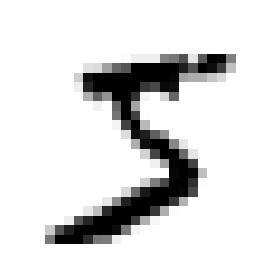

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("Some digit")
plt.show()

This looks like a 5, and the label correctly labeled it

In [6]:
y[0]

'5'

##### Note: The output of our labels (y) are strings, thus we should turn them into numbers so that our ML models can handle them correctly

In [7]:
y = y.astype(np.uint8)

Let's have a look at the complexity of the classification task

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [9]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows*images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row:(row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

Saving figure More digits


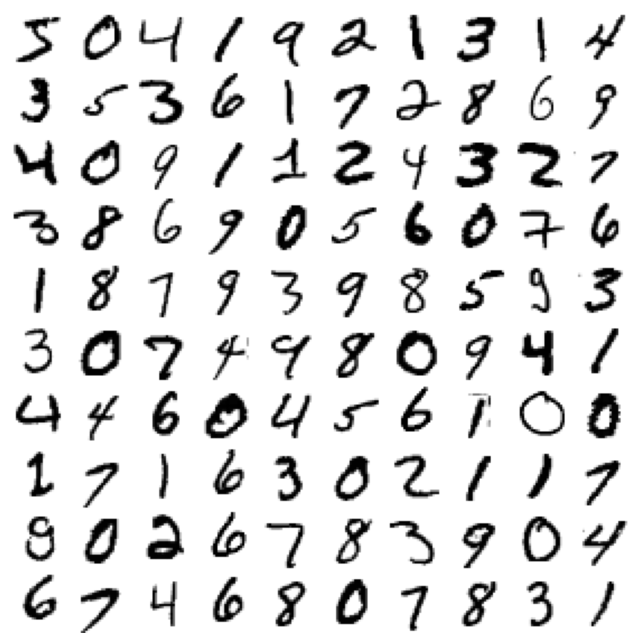

Figure 3-1


In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("More digits")
plt.show()
print("Figure 3-1")

Assign training and test sets

In [11]:
#MNIST dataset is already shuffled and splited into training set (first 60K)
#and test set (last 10K)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# End Of Section: MNIST

# Section: Training A Binary Classifier

In [12]:
#Let's simplify the problem by identifying only one digit
y_train_5 = (y_train == 5) #True for all #5, False for other digits
y_test_5 = (y_test == 5)

Use Stochastic Gradient Descent classifier to predict wehter a digit is 5 or not. This classifier has the advantages of handling very large datasets efficiently - deals with training instances independently, one at a time (good for online learning/out of core)

In [13]:
#sklearn.linear_model.SGDClassifier(loss="hinge", *, penalty="l2", alpha=0.0001,
#l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, 
#verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate="optimal",
#eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, 
#n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# End Of Section: Training A Binary Classifier

# Section: Performnace measures

##### Measuring accuracy using cross validation

You can implement cross validation with the following options

In [15]:
#Option #1 - Scikit Learn's StratifiedKFold
#sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, 
#random_state=None)
#Returns stratified folds
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train, y_train_5)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.95025
0.9522
0.95435


In [16]:
#Option #2 - Scikit Learn's cross_val_score()
#sklearn.model_selection(estimator, X, y=None, *, groups=None, scoring=None,
#cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch="2*n_jobs",
#error_score=nan)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

It seems like our accuracy scores are above 95%. Let's double check our results with a dumb classifier

In [17]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

It looks like our accuracy scores are above 90%, even for a dumb classifier. This is because roughly 10% of the images are 5, so the probabily of an image not being a 5 is very high. This comes to show that accuracy isn't the preferred performance measure for classifiers (specially when datasets are skewed to show some classes more than others)

##### Confusion matrix

A better way to analyze the performance of a classifier is using a confusion matrix. The main idea is to count the number of times an instance of A are classified as B

In [19]:
#To compute a confusion matrix we need to have a set of predictions first so 
#that we can compare them to the actual targets. Let's do this by using the 
#cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#Returns the prediction made in each fold

In [20]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in the confusion matrix represents an actual class, while each column represents a predicted class. So, from top right -> top left, bottom right -> bottom left: True negative -> false positiove, false negatives -> true positives

Let's pretend how a perfect matrix would look like; only have true positive and true negative

In [21]:
y_train_perfect_predictions = y_train_5 #Represents a perfect matrix
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

##### Precision and recall

Besides the confusion matrix, there are other metrics to consider. Namely, the precision of your classifier - the accuracy of the positive predictions. Alternatively, precision is used with anoter metric called recall(sensitivity) - measures the ratio of positive instances that are correctly detected

<img src="images/precision and recall.png" style="height:100px; margin-left:0;">

Let's compare the the above metrics using Scikit Learn's precision_score and recall_score

In [22]:
#Precision Score
precision_score(y_train_5, y_train_pred) #3530 / (3530 + 687)

0.8370879772350012

In [23]:
#Confusion Matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1]) #3530 / (687 + 3530)

0.8370879772350012

In [24]:
#Recall Score
recall_score(y_train_5, y_train_pred) #3530 / (1891 + 3530)

0.6511713705958311

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[1, 0] + cm[1, 1]) #3530 / (1891 + 3530)

0.6511713705958311

You can combine precision and recall into a single metric: F1 score. This metric calculates the harmonic mean of precision and recall. This means that low values recieve more weight rather than treat all values equally (like in the case of a regular mean). Thus, F1 score will be high only if both precision and recall are high

<img src="images/F1 score.svg" style="height:60px; margin-left:0;">

f1_score(y_train_5, y_train_pred)

In [26]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2) #3530 / (3530 + (1891 + 687) / 2)

0.7325171197343847

Note: There are cases where you want high precision or high recall. The foremost would be a good idea when you have a classifier that detects videos that are safe for kid. It rejects many good videos (low recall), but only keeps safe ones(high precision). The latter might be good if your're trying to detect shoplifters from surveillance images; a 30% precision is fine as long as it has 99% recall, you might get a few false alerts, but almost all of the shoplifters will get caught

##### *Increasing precision reduces recall, and vice versa - The precision/recall trade-off 

##### Precision/recall trade off

In order to effectively understand this trade off, let's have a look at the SGDClassifier. For each instance, it comuptes it's score based on a decision function. If the score is greater than a threshold, it assign it to the positive class, otherwise to the negative class. Thus, increasing the threshold will increase the precision but lower the recall, and vice versa

<img src="images/SGD classifier threshold.png" style="height:150px;">


In [27]:
print("Figure 3-3")

Figure 3-3


Scikit Learn doesn't let you set the threshold directly, but you can access it's decision_function() method that returns a score for each instance. Using the method allows use to use any threshold we want to make predictions based on those scores

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
#SGDClassifier predicts true because it uses a threshold of 0
y_scores2 = sgd_clf.predict([some_digit])
y_scores2

array([ True])

In [30]:
#Checking the assumption with a threshold of 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
#Let's raise the threshold, to confirm that it decreases recall (see image above)
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

We decide which threshold to use by using cross_val_predict() to get the scores of all instances (with method="decision_function") and then use these scores with the precision_recall_curve() to compute precision and recall for all possible thresholds

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

In [33]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure Precision and recall vs threshold


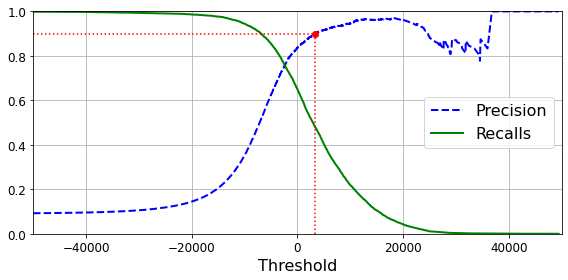

Figure 3-4


In [34]:
#Plot the curve with possible thresholds for precision and recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.9)] #Look for the lowest
#recall that gives at least 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)] #Look for the
#lowest threshold that gives at least 90% precision

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [threshold_90_precision, 
                                            threshold_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [threshold_90_precision], "ro")
save_fig("Precision and recall vs threshold")
plt.show()
print("Figure 3-4")

Generally, precision goes up but it our case it can go down sometimes. Refer back to the image to see that if we start at the center of the threshold and move one digit to the right the precision goes from 4/5(80%) to 3/4(75%). On the other hand, recall only decreases as the threshold increases

Saving figure Precision vs recall plot


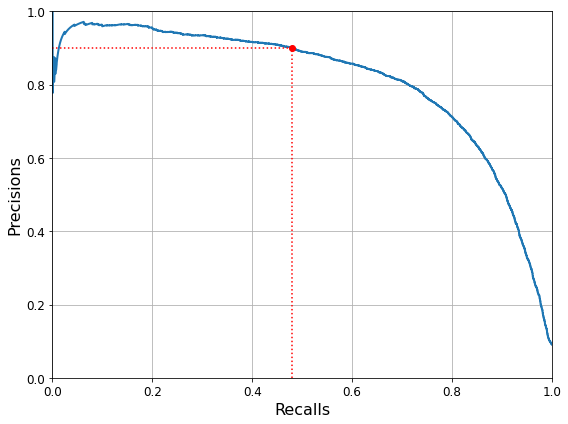

Figure 3-5


In [35]:
#Plot the curve for precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel("Recalls", fontsize=16)
    plt.ylabel("Precisions", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro:")
save_fig("Precision vs recall plot")
plt.show()
print("Figure 3-5")

Precision falls sharply around 80% recall, so it's best to choose a precision/recall trade off at around 60% recall

In [36]:
#Shows the lowest threshold value that gives at least 90% precision
threshold_90_precision

3370.0194991439557

In [37]:
#Make predictions using threshold_90_precision (instead of the classifiers 
#predict())
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
#Precision score
precision_score(y_train_5 ,y_train_pred_90)

0.9000345901072293

In [39]:
#Recall score
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

We now have a 90% precision classifier, as long as we set the threshold high enough. But high precision with low recall isn't very useful

##### The ROC(receiver operating characteristic) curve

Plots the true positive rate(TPR/recall) against the false positive rate(FPR). FPR = 1 - the true negative rate(TNR).
In other words, the ROC curve plots sensitivity (TPR/recall) versus specificity(FPR = 1- TNR)

In [40]:
#sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, 
#sample_weight=None, drop_intermediate=True)
#This Implementaion only works with binary classification
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

Saving figure ROC curve


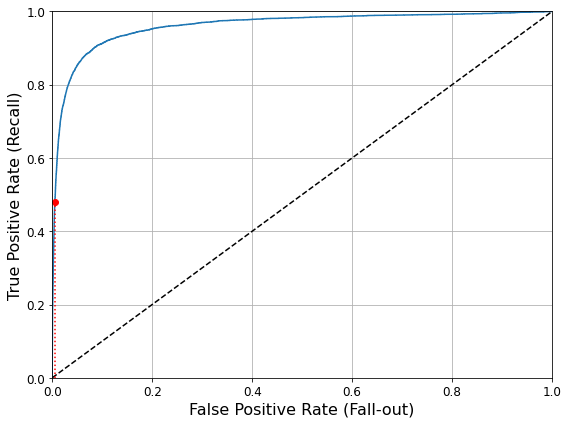

Figure 3-6


In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], "k--") #Dashed diagonal line
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (Fall-out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)] #Look for the lowest fpr
#with the lowest recall that gives at least 90% precision
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("ROC curve")
plt.show()
print("Figure 3-6")

From the plot we can see that the higher the recall (TPR), the more false positives (FPR). The red dot highlights the chosen ratio - 43.68% recall. The dotted line represents the ROC curve for a purely random classifier; a good classifier should be located towards the top left corner

Let's compare classifiers by measuring the area under the curve (AUC). Perfect classifiers have a ROC AUC = 1, while purely random classifiers have ROC AUC = 0.5

In [42]:
#sklear.metrics.roc_auc_score((y_true, y_score, *, average="macro", 
#sample_weight=None, max_fpr=None, multi_class="raise", labels=Non)
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### *Use PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use ROC curve

##### Comparing RandomForestClassifier's ROC curve and ROC AUC score to those of the SGDClassifier

##### *Note Scikit Learn classifiers generally have the decision_function() or predict_proba() or both 

In [43]:
#sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion="gini",
#max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features="auto", max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, 
#oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
#class_weight=None, ccp_alpha=0.0, max_samples=None)

#Random forest doesn't have a decision_function() method, but it has a 
#predict_proba() method that returns an array containing the probability that a
#given instance belongs to a given class


In [44]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method="predict_proba")

In [45]:
#The roc_curve() expects labels and scores, but instead of scores you can give
#it class probabilites. Let's use the positive class's probability as score
y_scores_forest = y_probas_forest[:, 1] #score = proba of the positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure Roc curve - comparison plot


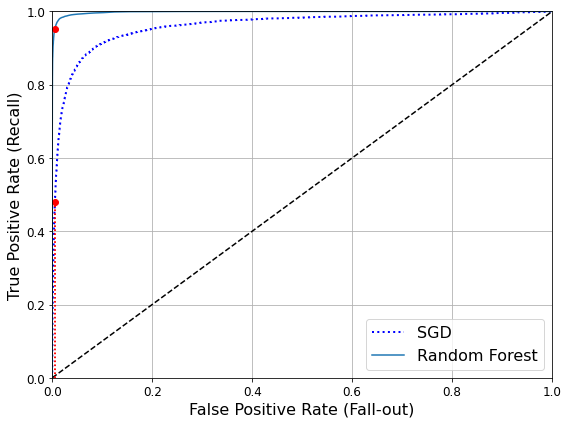

Figure 3-7


In [46]:
#Plot ROC curve
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("Roc curve - comparison plot")
plt.show()
print("Figure 3-7")

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

RandomForestClassifier is superior to the SGDClassifier because its ROC curve is much closer to the top left corner and has greater AUC as well (99.8% > 96%)

# End Of Section: Performnace Measures

# Section: Multiclass Classification

Unlike binary classifiers (logistic regression, SVM) some algorithms (SGD, random forest, naive bayes) are capable of handling multiple classes natively. However, there are various strategies to peform multiclass classification with multiple binary classifiers:
<ul>
    <li>One versus the rest (OvR): For digits between 0-9, you can train a system that classifies digits into 10 classes. Then, when you want to classify an image you get the decision score of every classifier and chose the highest score</li>
    <li>One versus one (OvO): Train a classifier for every pair of digits. If there are N classes you'll need to train N x (N-1)/2 classifiers. The MNIST would have 45 classifier and the winning classifier would be the class that won the most</li>
</ul>
The main advantage of OvO is that it's faster - each classifier needs to train only on the two classes that it must distinguish

In [48]:
#sklearn.svm.SVC(*, C=1.0, kernel="rbf", degree=3, gamma="scale", coef0=0.0, 
#shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None,
#verbose=False, max_iter=- 1, decision_function_shape="ovr", break_ties=False, 
#random_state=None)
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Examining the decision_function() we see that Scikit Learn used the OvO strategy. It returned 10 scores per instance. That's one score per class

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

The highest score is the one corresponding to class 5

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
svm_clf.classes_[5]

5

In [53]:
#Creating an OvR classifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_) #See how many classes there are

10

In [55]:
#Training a SGDClassifer
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [56]:
#Scores that the SGDClassifier assign to each class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [57]:
#Evaluate SGDClassifiers scores accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It get over 85% accuracy on all folds

In [58]:
#Scale the inputs to get a better accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# End Of Section: Multiclass Classification

# Section: Error Analysis

Let's say we found a promisin model. We should try to find ways to improve it. This is where analyzing the types of errors the model makes, comes in handy

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

KeyboardInterrupt: 

In [ ]:
#Convert to an image so that we can extract better insights
def plot_confusion_matrix(matrix):
    "This is a colorful example"
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    save_fig("Confusion matrix errors plot", tight_layout=False)

In [ ]:
plot_confusion_matrix(conf_mx)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The 5s look slighlty darker than other digits. Let's explore why is that

In [ ]:
#Devide each value in the confusion matrix by the number of images in the 
#corresponding class so that you get error rates instead of absolute numbers 
#(which would make abundant classes to look unfairly bad)
rows_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sums

In [ ]:
#Fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Recall that rows = actual classes, while columns = predicted classes. Class 8 is quite bright, which means that many images get misclassified as 8s. On the other hand, the row of 8 shows that actual 8s are generallu getting classified correctly. Evdintly, we can see that 3s and 5s get misclassified as well on both directions

The plot show us that we should focus on reducing the false 8s in order to get a better performance out of our model - add more images of 8s, preprocess the images to stand out more with certain patterns etc

Note: This strategy is more difficult and time consuming. 
It's possible to analyze individual errors. Although not recommended

In [ ]:
#Let's plot 3s and 5s 
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("Error analysis digits plot")
plt.show()

The blocks on the left are classified as 3s, while the blocks on the right are classified as 5s. 
If we look at the bottom left block, first row, second column, then we can understand why it was misclassified - it's hard for us too. But for the other digits, it's not as hard for us. Main reason is that we used a simple SGDClassifier, which is a linear model. It sums the weighted pixel intensities to get a score for each class. 3s and 5s differ only by a few pixels, that's why the model confuses them

This comes to show that the classifier is quite sensitive to shifting and rotation. So we can reduce the confusion/error by preprocessing the images to be well centered and not too rotated

# End Of Section: Error Analysis

# Section: Multilabel Classification

In the case of facial recognition classifier, you may want a single instance to be classified into multiple classes. Consider a system that needs to recognize several people in the same picture 

In [ ]:
#sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights="uniform",
#algorithm="auto", leaf_size=30, p=2, metric="minkowski", metric_params=None,
#n_jobs=None, **kwargs)
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

y_multilabel contains an array with two target labels for each digit image:
<ul>
    <li>The first - whether the digit is large (7, 8, 9)</li>
    <li>The second - whether it's odd</li>
</ul>

In [ ]:
knn_clf.predict([some_digit]) 
#Digit 5 is suppose to return [False, True], not bigger than 7 and is odd

Let's evaluate the multilabel classifier, selecting the right metrix depends on the project. The F1 score measures the score for each label and then computes the average score

##### *The following code may take a very long time (possibly hours depending on hardware)

In [ ]:
y_train_knn_pred = cross_val_predcit(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

We assume that all labels are equally important. In the case of a face recognition system, the person that appears more often in pictures should receive more weight on their score. In other words, give each label a weight equal to it's support (the number of instances with that target label). You can do this by setting average="weighted

# End Of Section: Multilabel Classification

# Section: Multioutput Classification

This type of classification is simply a generalization of multilabel classificaiton where each label can be multiclass - it can have more than 2 possible values

Let's illustrate this by building a system that removes noises from images. It will take a noisy digit image and output a clean digit image, represented as an array of pixel intesities. Note: the classifier output is multilabeled (one label per pixel) and each label can have multiple values (pixel intensities range from 0 to 255)

In [ ]:
#Make train and test set from MNIST
noise = np.random.randint(0, 100, (len(X_train), 784)) #Adding noise with randint()
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784)) #Adding noise with randint()
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's have a look at an image from the test set

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("Noisy digit example")
plt.show()

Let's clean the noisy image

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# End Of Section: Multioutput Classification

# Section: Exercise Solutions

## 1

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

##### *The following code may take a very long time (psosibly hours depending on hardware)

In [ ]:
param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_seach.best_score_

In [ ]:
y_pred = grid_seach.predict(X_test)
accuracy_score(y_test, y_pred)

## 2

Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel. Then, for each image in the training set, create four shifted
copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.

In [71]:
#scipy.ndimage.shift(input, shift, output=None, order=3, mode="constant", 
#cval=0.0, prefilter=True)
#Returns the shifted input

def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy,dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

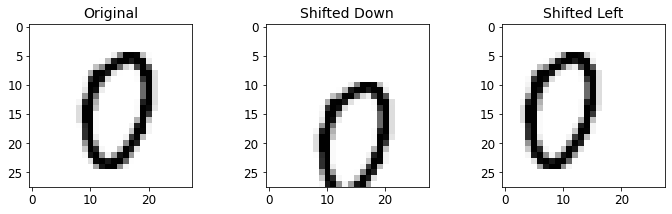

In [69]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted Down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted Left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.show()

In [74]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [77]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [80]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

NameError: name 'grid_search' is not defined

In [82]:
knn_clf.fit(X_train_augmented, y_train_augmented)

NameError: name 'knn_clf' is not defined

##### *The following code may take a very long time (psosibly hours depending on hardware)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

## 3

Tackle the Titanic dataset. A great place to start is on Kaggle.

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

In [83]:
TITANIC_PATH = os.path.join("datasets", "Titanic")

In [85]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [86]:
train_data = load_titanic_data("train.csv") 
test_data = load_titanic_data("test.csv")

Luckily, the data is already split into training and test set. However, the test set doesn't contain any of the label, thus our goal is to train the best model in the training data in order to make predictions on the test data

In [87]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's explore the data to see if there are any values missing

In [89]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


List of attributes and their meaning:
<ul>
    <li>
        <strong>Survived:</strong> The target attribute: 0 - didn't survive, 1 - survived
    </li>
    <li>
        <strong>Pclass:</strong> Passenger class
    </li>
    <li>
        <strong>Name, Sex, Age:</strong> Self-explanatory
    </li>
    <li>
        <strong>SibSp:</strong> How many siblings & spouses of the passenger aboard the Titanic
    </li>
    <li>
        <strong>Parch:</strong> How many children & parents of the passenger aboard the Titanic
    </li>
    <li>
        <strong>Ticket:</strong> Ticket id
    </li>
    <li>
        <strong>Fare:</strong> Price for ticket(£)
    </li>
    <li>
        <strong>Cabin:</strong> Passenger's cabin number
    </li>
    <li>
        <strong>Embarked:</strong> Where the passenger embarked the Titanic
    </li>
</ul>

We can see from the information above that attributes: <strong>Age</strong>, <strong>Cabin</strong>, and <strong>Embarked</strong> have missing values (less than 891 non nulls). Let's ignore <strong>Cabin</strong> for now and focus on the rest

For the <strong>Age</strong> attribute, we will replace the missing values with the median age

##### Check the numerical attributes

In [90]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that the mean for <strong>Survived</strong> attribute is 38%. Let's check if this actually represents the number of survivors

In [92]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

##### Check the categorical attribute

In [93]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [94]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [95]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

For the <strong>Embarked</strong> category: S=South Hampton, C=Cherbourg, Q=Queens Town

In [98]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X,):
        return X[self.attribute_names]

Pipeline for the numerical attributes (filling in the missing attributes with the median value of the column)

In [103]:
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
])

In [104]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We also need an imputer for the categorical attributes (SimpleImputer doesn't work for string cateforical attributes)

In [118]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Pipeline for the categorical attributes

In [119]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False)), #sparse=False -> return an array instead of sparse matrix
])

In [120]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, combine the numerical and categorical attributes

In [166]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

Now we have a preprocessing pipeline that takes in raw data and outputs numerical input features that we can feed to a ML model


In [167]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Get the labels

In [169]:
y_train = train_data["Survived"]

Let's train a SVC classifier

In [173]:
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [191]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Evaluate the model with cross validation

In [175]:
svm_score = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_score.mean()

0.7329588014981274

Try a RandomForestClassifier to see if we can get a better score

In [179]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_score = cross_val_score(rnd_clf, X_train, y_train, cv=10)
rnd_score.mean()

0.8126466916354558

Plot all 10 scores for each model

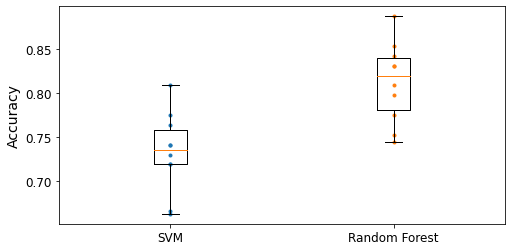

In [180]:
plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_score, ".")
plt.plot([2]*10, rnd_score, ".")
plt.boxplot([svm_score, rnd_score], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

##### Feature Engineering

Let's put the age into corresponding age buckets, and use it instead of age

In [181]:
train_data["AgeBucket"] = train_data["Age"] // 15*15

In [186]:
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


Let's make another category that shows how many people are traveling with each passenger, seems like passengers travelling alone have 30% of surviving

In [202]:
train_data["RelativesOnBoard"] = train_data["SibSp"] + train_data["Parch"]

In [206]:
train_data[["RelativesOnBoard", "Survived"]].groupby(["RelativesOnBoard"]).mean()

,Survived
RelativesOnBoard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [211]:
num_pipeline_with_agebucket = Pipeline([
    ("select_num", DataFrameSelector(["AgeBucket", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
])

In [208]:
num_pipeline_with_agebukcet.fit_transform(train_data)

array([[15.    ,  1.    ,  0.    ,  7.25  ],
       [30.    ,  1.    ,  0.    , 71.2833],
       [15.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [15.    ,  1.    ,  2.    , 23.45  ],
       [15.    ,  0.    ,  0.    , 30.    ],
       [30.    ,  0.    ,  0.    ,  7.75  ]])

In [209]:
cat_pipeline_with_relatives = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked", "RelativesOnBoard"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False)), #sparse=False -> return an array instead of sparse matrix
])

In [210]:
cat_pipeline_with_relatives.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [213]:
preprocess_pipeline_with_age_rela = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline_with_agebucket),
    ("cat_pipeline", cat_pipeline_with_relatives),
])

In [216]:
X_train_new = preprocess_pipeline_with_age_rela.fit_transform(train_data)
X_train_new

array([[15.,  1.,  0., ...,  0.,  0.,  0.],
       [30.,  1.,  0., ...,  0.,  0.,  0.],
       [15.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [15.,  1.,  2., ...,  0.,  0.,  0.],
       [15.,  0.,  0., ...,  0.,  0.,  0.],
       [30.,  0.,  0., ...,  0.,  0.,  0.]])

In [217]:
rnd_clf_for_new_pipe = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf_for_new_pipe_score = cross_val_score(rnd_clf_for_new_pipe, X_train_new,
                                             y_train, cv=10)
rnd_clf_for_new_pipe_score.mean()

0.8069912609238452

Looks like we haven't achieved a higher score after the feature engineering

## 4

Build a spam classifier